<a href="https://colab.research.google.com/github/vijaynadimpalli/numer_ai_experiments/blob/master/Pairs_Trading_(mlfinlab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
!pip install hurst
from hurst import compute_Hc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!git clone https://github.com/hudson-and-thames/oct_applications.git

shutil.copy('/content/oct_applications/aarondeb/data/data.csv','.')

Cloning into 'oct_applications'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 183 (delta 8), reused 25 (delta 2), pack-reused 147
Receiving objects: 100% (183/183), 54.15 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (48/48), done.


'./data.csv'

In [ ]:
class PairSelector():
  def __init__(self,stocks):

    if stocks is None:
      raise Exception("Empty dataset recieved")
    if not isinstance(stocks,pd.DataFrame):
      raise Exception("Not a DataFrame")

    self.data = stocks
    self.pairs = []

  def pairs_checks(self):
    self.max_cluster = self.clusters['cluster_ID'].max()

    self.clust_data = pd.concat([self.reduced_data,self.clusters],axis=1)
    self.clust_data = self.clust_data.set_index([self.clust_data['cluster_ID'],self.clust_data.index]).drop(['cluster_ID'],axis=1)

    for ind in range(self.max_cluster + 1):
      cluster = self.clust_data.loc[ind,:]
      for pair in self.get_pairs(cluster.index):

        #Step 1
        pair,checker = self.check_coint(pair)
        if checker is False:
          continue

        #Step 2,3 and 4
        try:
          checker = self.spread_calcs(pair)
        except FloatingPointError:
          print(f"Divide by zero for pair : {pair}")      
          checker = False

        if checker is False:
          continue

        self.pairs.append(pair)

    print(self.pairs)

  
  # def plot_pairs(self):
  #   for
   


  def cluster_algo(self):
    self.clusters = OPTICS().fit(self.reduced_data).labels_
    self.clusters = pd.DataFrame(self.clusters,self.reduced_data.index,columns=['cluster_ID'])

  
  def plot_pca_matrix(self):
    pd.plotting.scatter_matrix(self.reduced_data)

  def dimension_reduction(self,n_dims=10):
    self.returns = self.data

    self.returns = (self.data - self.data.shift(1))/self.data.shift(1)
    self.returns.replace([np.inf,-np.inf],[np.nan,np.nan],inplace=True)
    self.returns.dropna(inplace=True)

    scaler = StandardScaler()
    self.returns = pd.DataFrame(scaler.fit_transform(self.returns))
    pca = PCA(n_dims)
    pca.fit(self.returns)

    self.reduced_data = pd.DataFrame(pca.components_)    
    self.reduced_data.columns = self.data.columns
    self.reduced_data = self.reduced_data.T

  @staticmethod
  def get_pairs(tickers):
    for i in range(len(tickers)):
      for j in range(i+1,len(tickers)):
        yield (tickers[i],tickers[j])


  def check_coint(self,pair):
    t_1,p_1,_ = coint(self.data[pair[0]],self.data[pair[1]])
    t_2,p_2,_ = coint(self.data[pair[1]],self.data[pair[0]])

    if p_1 > 0.05 and p_2 > 0.05:
      return (pair,False)

    ret_pair = None
    if p_1 <= 0.05:
      ret_pair = pair

    if p_2 <= 0.05 and ret_pair is not None and t_2 < t_1:
      ret_pair = (pair[1],pair[0])

    if ret_pair is None:
      ret_pair = (pair[1],pair[0])

    return (ret_pair,True)


  def spread_calcs(self,pair):  
    #Step 2
    spread = (self.data[pair[0]] - self.data[pair[1]]) 
    H, c, _ = compute_Hc(spread, kind='price', simplified=False)
    if H >= 0.5:
      return False

    #Step3
    spread_np = spread.values.reshape(-1,1)
    spread_lag = spread_np[:-1]
    spread_ret = spread_np[1:] - spread_lag

    lm = LinearRegression().fit(spread_ret,spread_lag)
    halflife = -np.log(2) / lm.coef_[0,0]
    if halflife < 1.0 or halflife > 250.0:
      return False

    #Step 4
    spread_mean = spread.rolling(window=30).mean()[30:]
    spread = spread[30:]
    count_crossing = 0
    for ind,_ in enumerate(spread_mean[1:]):
      if (spread_mean[ind] >= spread[ind] and spread_mean[ind-1] < spread[ind-1]) or (spread_mean[ind] <= spread[ind] and spread_mean[ind-1] > spread[ind-1]):
        count_crossing += 1
    
    if count_crossing * 252.0 / len(spread) < 12.0:
      return False

    return True

In [ ]:
df = pd.read_csv("data.csv",parse_dates=True,index_col='Date').dropna()

pairs = PairSelector(df)

pairs.dimension_reduction(10)

pairs.cluster_algo()

pairs.pairs_checks()

Divide by zero for pair : ('MDLZ', 'CHD')
[('LH', 'UNH'), ('QRVO', 'AAPL'), ('AMAT', 'MCHP'), ('MDT', 'EW'), ('EW', 'ZTS'), ('SYK', 'IQV'), ('FITB', 'TFC'), ('LNT', 'CMS'), ('PEP', 'MDLZ')]


In [ ]:
#pairs.plot_pairs()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(42)

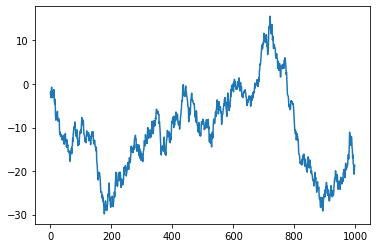

In [ ]:
ts = np.random.randn(1000).cumsum()
plt.plot(ts)

In [ ]:
from sklearn.linear_model import LinearRegression

def get_hurst(ts):

  if not isinstance(ts,pd.Series):
    ts = pd.Series(ts)

  n = len(ts)
  mean = ts.mean()
  y = ts - mean
  z = y.expanding().sum()
  r  = z.expanding().max() - z.expanding().min()

  s = ts.expanding().std()

  rs = r/s

  return LinearRegression().fit(np.log())

In [ ]:
get_hurst(ts)

In [ ]:
temp = np.arange(1,100,1).reshape(-1,1)

model = LinearRegression().fit(temp,temp*2)






In [ ]:
model.coef_[0,0]

2.0000000000000004

In [ ]:
!pip install mlfinlab

     |████████████████████████████████| 983kB 4.1MB/s 
     |████████████████████████████████| 6.9MB 12.0MB/s 
     |████████████████████████████████| 112kB 38.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.1MB 34.9MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 12.4MB 183kB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 430kB 46.7MB/s 
     |████████████████████████████████| 3.6MB 51.1MB/s 
     |████████████████████████████████| 1.6MB 46.3MB/s 
     |████████████████████████████████| 993kB 47.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.7MB 36.2MB/s 
     |██████████████████

In [ ]:
import mlfinlab

In [ ]:
from mlfinlab import backtests,feature_importance

In [ ]:
feature_importance.ClassificationModelFingerprint()